In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys
import matplotlib.pyplot as plt
import dill

sys.path.append('/data/users/morton/git/icrpythonradiomics/machineLearning')
from featureSelection import featureSelection_correlation, featureSelection_groupName


In [24]:
# function to make group strings easier to read
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

In [2]:
# open clinical spreadsheet
clinicalSpreadsheet = '/Users/morton/Dicom Files/RADSARC_R/ClinicalData/Clinical data for analysis.xlsx'
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', engine='openpyxl')
dfClinical = dfClinical[['Anon Code', 'Grade', 'subtype']]

In [3]:
# open radiomics data
dfRad = pd.read_csv('/Users/morton/Dicom Files/RADSARC_R/XNAT/extractions/extractions__20220910_1006_allRegions/radiomicFeatures/radiomicFeatures.csv')
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# select only the standard feature set from the whole lesion
featureSet = 'lesion_original'
#featureSet = 'lesion_calcificationDeleted_original'
dfRad = dfRad.filter(regex=featureSet + '|StudyPatientName')
dfRad.rename(lambda x:x.replace(featureSet+'_',''), axis=1, inplace=True)

In [4]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)
df.drop('Grade', axis=1, inplace=True)
target = 'subtype'

In [27]:
X = df.drop(target, axis=1)
y = df[target]

#correlationHierarchy = []
correlationHierarchy = ['shape_MeshVolume', 'shape', 'firstorder']

#groupHierarchy = ['']
textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
groupHierarchy = ['MeshVolume', 'shape', 'firstorder|histogram', textureStr, 'shape|firstorder|histogram', 'shape|'+textureStr, 'firstorder|histogram|'+textureStr, '']

pipe = Pipeline([('correlationSelector', featureSelection_correlation(threshold=0.6, exact=False, featureGroupHierarchy=correlationHierarchy)),
                 ('groupSelector', featureSelection_groupName()),
                 ('scaler', StandardScaler()),
                 ('lr', LogisticRegression(solver="liblinear", max_iter=10000, penalty='l1'))])

p_grid = {"lr__C": np.logspace(np.log10(0.2), np.log10(2), 5),
          "groupSelector__groupFilter": groupHierarchy}

Threshold = 0.6, AUROC = 0.851 ± 0.0989
Threshold = 0.62, AUROC = 0.868 ± 0.0877
Threshold = 0.64, AUROC = 0.867 ± 0.0897
Threshold = 0.66, AUROC = 0.866 ± 0.0906
Threshold = 0.68, AUROC = 0.875 ± 0.0892
Threshold = 0.7, AUROC = 0.874 ± 0.0891
Threshold = 0.72, AUROC = 0.873 ± 0.0883
Threshold = 0.74, AUROC = 0.871 ± 0.0913
Threshold = 0.76, AUROC = 0.871 ± 0.0925
Threshold = 0.78, AUROC = 0.871 ± 0.0923
Threshold = 0.8, AUROC = 0.869 ± 0.0916
Threshold = 0.82, AUROC = 0.869 ± 0.0862
Threshold = 0.84, AUROC = 0.875 ± 0.0851
Threshold = 0.86, AUROC = 0.875 ± 0.084
Threshold = 0.88, AUROC = 0.872 ± 0.0834
Threshold = 0.9, AUROC = 0.892 ± 0.0739
Threshold = 0.92, AUROC = 0.897 ± 0.0727
Threshold = 0.94, AUROC = 0.906 ± 0.0745
Threshold = 0.96, AUROC = 0.905 ± 0.0709
Threshold = 0.98, AUROC = 0.9 ± 0.0705
Threshold = 1.0, AUROC = 0.902 ± 0.0688


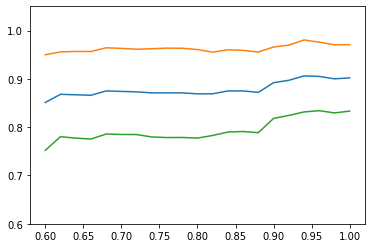

In [6]:
experiments = {}
thresholds = np.arange(0.6,1.001,0.02) #02)
cv_mean = []
cv_std = []
for threshold in thresholds:
    
    pipe.steps[0][1].threshold = threshold

    random_state = 42
    np.random.seed(random_state)

    inner_cv = StratifiedKFold(n_splits=5)
    model = GridSearchCV(estimator=pipe, param_grid=p_grid, cv=inner_cv, refit=True, verbose=0, scoring='neg_log_loss', n_jobs=-1)
    model.fit(X, y)

    # set to 1 ready for using n_jobs = -1 for cross validation
    model.n_jobs = 1

    n_splits = 10
    n_repeats = 20
    validation = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

    # supress warnings for cross_validate
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    #
    cv_result = cross_validate(model, X, y, cv=validation, scoring='roc_auc', return_estimator=True, n_jobs=-1)
    #
    warnings.simplefilter('default')
    os.environ["PYTHONWARNINGS"] = 'default'

    experiments[str(threshold)] = {'model':copy.deepcopy(model), 'cv_result':copy.deepcopy(cv_result)}
    
    cv_mean.append(np.round(np.mean(cv_result['test_score']),3))
    cv_std.append(np.round(np.std(cv_result['test_score']),4))
    
    print('Threshold = ' + str(np.round(threshold,2)) + ', AUROC = ' + str(cv_mean[-1]) + ' \u00B1 ' + str(cv_std[-1]))
    
plt.plot(thresholds, cv_mean)
plt.plot(thresholds, np.array(cv_mean) + np.array(cv_std))
plt.plot(thresholds, np.array(cv_mean) - np.array(cv_std))
plt.ylim([0.6, 1.05])
plt.show()

In [130]:
thresholdStr = '0.8000000000000002'
model = experiments[thresholdStr]['model']
cv_result = experiments[thresholdStr]['cv_result']

In [131]:
groupStrsDisp(model.best_estimator_.steps[1][1].groupFilter)

'shape|firstorder'

In [132]:
colMask0 = copy.deepcopy(model.best_estimator_.steps[0][1].mask_)
colMask1 = model.best_estimator_.steps[1][1].colMask_
colMask0[colMask0] = colMask1
bc = np.zeros((X.shape[1]))
bc[colMask0] = copy.deepcopy(model.best_estimator_._final_estimator.coef_).ravel()
coef = pd.DataFrame({'Feature':list(np.array(X.columns)[bc != 0]), 'Coef':list(bc[bc != 0])})
coef = coef.sort_values(by='Coef', ascending=False, key=abs)
coef = coef.loc[coef.Coef != 0,:]
coef.style.hide_index()

In [133]:
print('AUROC (CV) = ' + str(np.round(np.mean(cv_result['test_score']),5)))

AUROC (CV) = 0.8686


In [134]:
group_cv_counts = {}
group_cv = [groupStrsDisp(x.best_estimator_.steps[1][1].groupFilter) for x in cv_result['estimator']]
for group in groupStrsDisp(groupHierarchy):
    group_cv_counts[group] = len([x for x in group_cv if x==group])
pd.DataFrame({'Group':group_cv_counts.keys(), 'Frequency':group_cv_counts.values()}).style.hide_index()

In [135]:
bc = np.zeros((len(cv_result['estimator']), X.shape[1]))
for n, ecv in enumerate(cv_result['estimator']):
    colMask0 = copy.deepcopy(ecv.best_estimator_.steps[0][1].mask_)
    colMask1 = ecv.best_estimator_.steps[1][1].colMask_
    colMask0[colMask0] = colMask1
    bc[n, colMask0] = copy.deepcopy(ecv.best_estimator_._final_estimator.coef_)
    coef = pd.DataFrame({'Feature':list(np.array(X.columns)[bc[n,:].ravel() != 0]), 'Coef':list(bc[n,bc[n,:] != 0])})
    coef = coef.sort_values(by='Coef', ascending=False, key=abs)
    coef = coef.loc[coef.Coef != 0,:]
    print(ecv.best_estimator_.steps[1][1].groupFilter)
    display(coef.style.hide_index())
    print('\n')



firstorder|histogram|glcm|gldm|glszm|glrlm|ngtdm




shape




firstorder|histogram|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram|glcm|gldm|glszm|glrlm|ngtdm




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram|glcm|gldm|glszm|glrlm|ngtdm




firstorder|histogram




shape




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape|glcm|gldm|glszm|glrlm|ngtdm




firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




shape|firstorder|histogram




shape




shape|firstorder|histogram




shape




firstorder|histogram




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape




shape|firstorder|histogram




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape




shape




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




firstorder|histogram|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




shape|firstorder|histogram




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|glcm|gldm|glszm|glrlm|ngtdm




firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram




shape|firstorder|histogram


In [136]:
pdFreq = pd.DataFrame({'Feature':X.columns, 'Frequency':np.sum(bc !=0, axis=0)})
pdFreq = pdFreq.loc[pdFreq.Frequency>0,:].sort_values(by='Frequency', ascending=False, key=abs)
pdFreq.style.hide_index()

In [137]:
C = []
for est in cv_result['estimator']:
    C.append(copy.deepcopy(est.best_estimator_.steps[3][1].C))
np.round(C,3)

array([0.356, 0.632, 0.632, 0.356, 0.632, 1.125, 0.356, 1.125, 0.632,
       0.632, 0.632, 2.   , 0.356, 0.632, 1.125, 1.125, 0.356, 0.356,
       0.632, 0.356, 2.   , 0.632, 0.632, 1.125, 0.356, 0.632, 1.125,
       0.356, 0.632, 0.632, 1.125, 1.125, 0.356, 0.356, 0.356, 1.125,
       0.356, 0.632, 1.125, 0.356, 1.125, 0.632, 0.632, 1.125, 0.356,
       0.356, 0.356, 0.356, 0.632, 0.632, 2.   , 0.632, 0.356, 0.632,
       0.356, 0.632, 0.632, 0.632, 0.356, 0.632, 0.356, 0.632, 1.125,
       0.356, 1.125, 0.632, 0.632, 0.632, 0.356, 0.356, 0.632, 0.632,
       2.   , 0.632, 0.356, 1.125, 0.632, 0.356, 0.632, 1.125, 0.632,
       0.632, 0.632, 1.125, 0.356, 0.632, 0.632, 0.632, 1.125, 1.125,
       1.125, 0.356, 1.125, 0.632, 0.632, 0.356, 0.356, 0.632, 0.356,
       0.356, 0.356, 0.632, 0.356, 1.125, 0.356, 0.356, 0.356, 0.632,
       0.356, 0.356, 0.632, 1.125, 0.632, 0.632, 0.356, 0.632, 2.   ,
       0.632, 0.356, 0.356, 0.356, 1.125, 0.632, 1.125, 0.356, 0.356,
       0.356, 1.125,

In [168]:
# uncomment whichever is needed

#dill.dump_session('/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/GroupSelectionBasicFeatures_evaluateCorrelationThrehold/fittedModels.pkl')
#dill.load_session('/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/GroupSelectionBasicFeatures_evaluateCorrelationThrehold/fittedModels.pkl')

In [169]:
colNames = groupStrsDisp(groupHierarchy)
colNames.insert(0, 'threshold')
groupFrequencyDf = pd.DataFrame(columns=colNames)

for threshStr, result in experiments.items():
    cv_result = result['cv_result']
    group_cv_counts = {}
    group_cv = [groupStrsDisp(x.best_estimator_.steps[1][1].groupFilter) for x in cv_result['estimator']]
    groupCounts = [0]*len(groupHierarchy)
    for n, group in enumerate(groupStrsDisp(groupHierarchy)):
        groupCounts[n] = len([x for x in group_cv if x==group])
    groupCounts = [x/np.sum(groupCounts) for x in groupCounts]
    groupCounts.insert(0, float(threshStr))
    groupFrequencyDf = groupFrequencyDf.append(pd.DataFrame(data=[groupCounts], columns=colNames))
groupFrequencyDf = groupFrequencyDf.reset_index(drop=True)

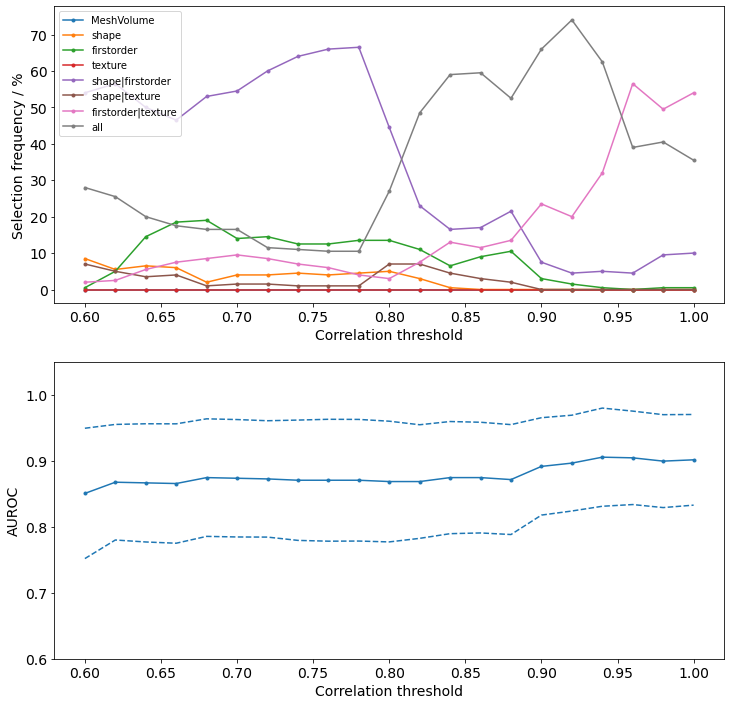

In [170]:
plt.rcParams['font.size'] = '14'
f,a = plt.subplots(2,1, figsize=(12,12))
for group in groupStrsDisp(groupHierarchy):
    a[0].plot(groupFrequencyDf['threshold'], 100*groupFrequencyDf[group], label=group, marker='.')
a[0].legend(fontsize=10)
a[0].set_xlabel('Correlation threshold')
a[0].set_ylabel('Selection frequency / %')

a[1].plot(thresholds, cv_mean, marker='.')
a[1].plot(thresholds, np.array(cv_mean) + np.array(cv_std), linestyle='--', color='C0')
a[1].plot(thresholds, np.array(cv_mean) - np.array(cv_std), linestyle='--', color='C0')
a[1].set_ylim([0.6, 1.05])
a[1].set_xlabel('Correlation threshold')
a[1].set_ylabel('AUROC')

plt.show()

In [211]:
# experiments.keys()

In [214]:
# get the experiment with threshold = 0.8

thresholdStr = '0.7800000000000001'
#thresholdStr = '0.9400000000000003'
model = experiments[thresholdStr]['model']
cv_result = experiments[thresholdStr]['cv_result']

In [215]:
print('AUROC (CV) = ' + str(np.round(np.mean(cv_result['test_score']),5)))

AUROC (CV) = 0.87052


In [216]:
# from fit to all data get the best feature group combination
groupStrsDisp(model.best_estimator_.steps[1][1].groupFilter)

'shape|firstorder'

In [1]:
# from fit to all data get the non-zero LR coefficients
colMask0 = copy.deepcopy(model.best_estimator_.steps[0][1].mask_)
colMask1 = model.best_estimator_.steps[1][1].colMask_
colMask0[colMask0] = colMask1
bc = np.zeros((X.shape[1]))
bc[colMask0] = copy.deepcopy(model.best_estimator_._final_estimator.coef_).ravel()
bestCoef = pd.DataFrame({'Feature':list(np.array(X.columns)[bc != 0]), 'Coef':list(bc[bc != 0])})
bestCoef = bestCoef.sort_values(by='Coef', ascending=False, key=abs)
bestCoef = bestCoef.loc[bestCoef.Coef != 0,:]
bestCoef.style.hide_index()

NameError: name 'copy' is not defined

In [237]:
# get frequency that each feature is selected

bc = np.zeros((len(cv_result['estimator']), X.shape[1]))
for n, ecv in enumerate(cv_result['estimator']):
    colMask0 = copy.deepcopy(ecv.best_estimator_.steps[0][1].mask_)
    colMask1 = ecv.best_estimator_.steps[1][1].colMask_
    colMask0[colMask0] = colMask1
    bc[n, colMask0] = copy.deepcopy(ecv.best_estimator_._final_estimator.coef_)
    coef = pd.DataFrame({'Feature':list(np.array(X.columns)[bc[n,:].ravel() != 0]), 'Coef':list(bc[n,bc[n,:] != 0])})
    coef = coef.sort_values(by='Coef', ascending=False, key=abs)
    coef = coef.loc[coef.Coef != 0,:]

pdFreq = pd.DataFrame({'Feature':X.columns, 'Frequency':np.sum(bc !=0, axis=0)/(n_splits*n_repeats)*100})

# add coeff values for best fit
pdFreq['Coef'] = ''
for _, row in bestCoef.iterrows():
    rowIndex = pdFreq.index[pdFreq.Feature == row.Feature].tolist()[0]
    pdFreq.loc[rowIndex,'Coef'] = row.Coef

pdFreq = pdFreq.loc[pdFreq.Frequency>0,:].sort_values(by='Frequency', ascending=False, key=abs)

pd.set_option('display.precision', 2)
pdFreq.style.hide_index()

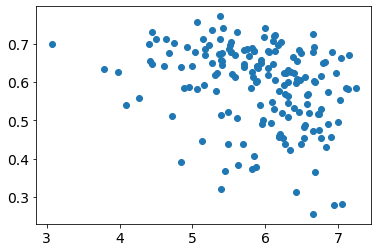

In [243]:
plt.scatter(np.log10(df['shape_MeshVolume']), df['shape_Sphericity'])